In [1]:

#8) Fit the same model from before with the same priors,  but this time use nested sampling.

#$y = b$, for $t<t_0$

#$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

#Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

#An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

#9) Another possible model that may explain the data is a Gaussian profile described by:

#$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

#Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

#10) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import warnings

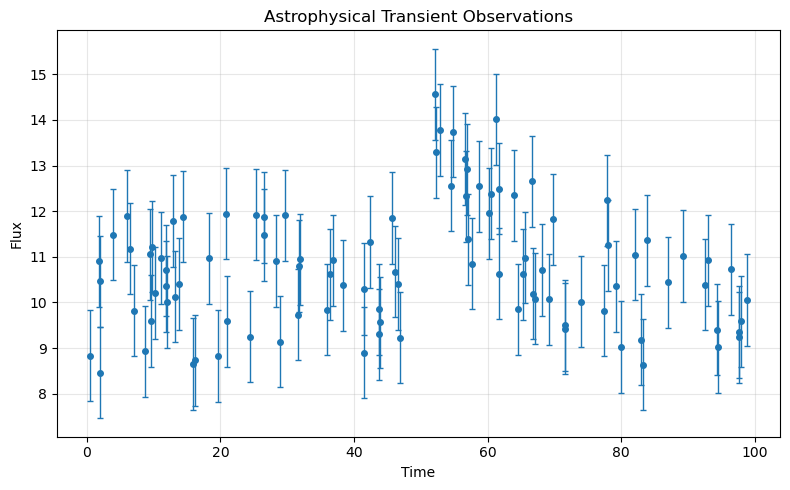

In [3]:

# Load and plot data
def load_data(path="transient.npy"):
    data = np.load(path)
    t, y, yerr = data.T
    return t, y, yerr

def quick_plot_data(t, y, yerr, title="Astrophysical Transient Observations"):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.errorbar(t, y, yerr=yerr, fmt='o', ms=4, lw=1, capsize=2)
    ax.set_xlabel("Time")
    ax.set_ylabel("Flux")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

t, y, yerr = load_data("transient.npy")
quick_plot_data(t, y, yerr)

data = (t, y, yerr)


In [4]:

#Define Models  (theta = [A, b, t0, shape])
def burst_model(theta, t):
    A, b, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))

def gaussian_model(theta, t):
    A, b, t0, sigmaW = theta
    return b + A * np.exp(-((t - t0) ** 2) / (2.0 * sigmaW ** 2))


In [5]:
# Gaussian log-likelihood (homoscedastic sigma provided)
def loglike_burst(theta, data):
    t, y, yerr = data
    mu = burst_model(theta, t)
    return -0.5 * np.sum(((y - mu) / yerr) ** 2)

def loglike_gaussian(theta, data):
    t, y, yerr = data
    mu = gaussian_model(theta, t)
    return -0.5 * np.sum(((y - mu) / yerr) ** 2)


In [6]:
#  Priors -> unit-cube transforms for dynesty

# Burst: A~U(0,50), b~U(0,50), t0~U(0,100), ln(alpha)~U(-5,5)  -> alpha>0
def prior_transform_burst(u):
    u = np.asarray(u)
    A  = u[0] * 50.0
    b  = u[1] * 50.0
    t0 = u[2] * 100.0
    ln_alpha = -5.0 + u[3] * (5.0 - (-5.0))
    alpha = np.exp(ln_alpha)
    return np.array([A, b, t0, alpha])

# Gaussian: A~U(0,50), b~U(0,50), t0~U(0,100), ln(sigmaW)~U(-2,2) -> sigmaW>0
def prior_transform_gaussian(u):
    u = np.asarray(u)
    A  = u[0] * 50.0
    b  = u[1] * 50.0
    t0 = u[2] * 100.0
    ln_sigma = -2.0 + u[3] * (2.0 - (-2.0))
    sigmaW = np.exp(ln_sigma)
    return np.array([A, b, t0, sigmaW])


8021it [00:16, 484.40it/s, +400 | bound: 111 | nc: 1 | ncall: 172730 | eff(%):  4.887 | loglstar:   -inf < -48.755 <    inf | logz: -64.171 +/-  0.187 | dlogz:  0.000 >  0.010]
7937it [00:14, 566.79it/s, +400 | bound: 108 | nc: 1 | ncall: 169928 | eff(%):  4.918 | loglstar:   -inf < -52.403 <    inf | logz: -67.611 +/-  0.182 | dlogz:  0.000 >  0.010]


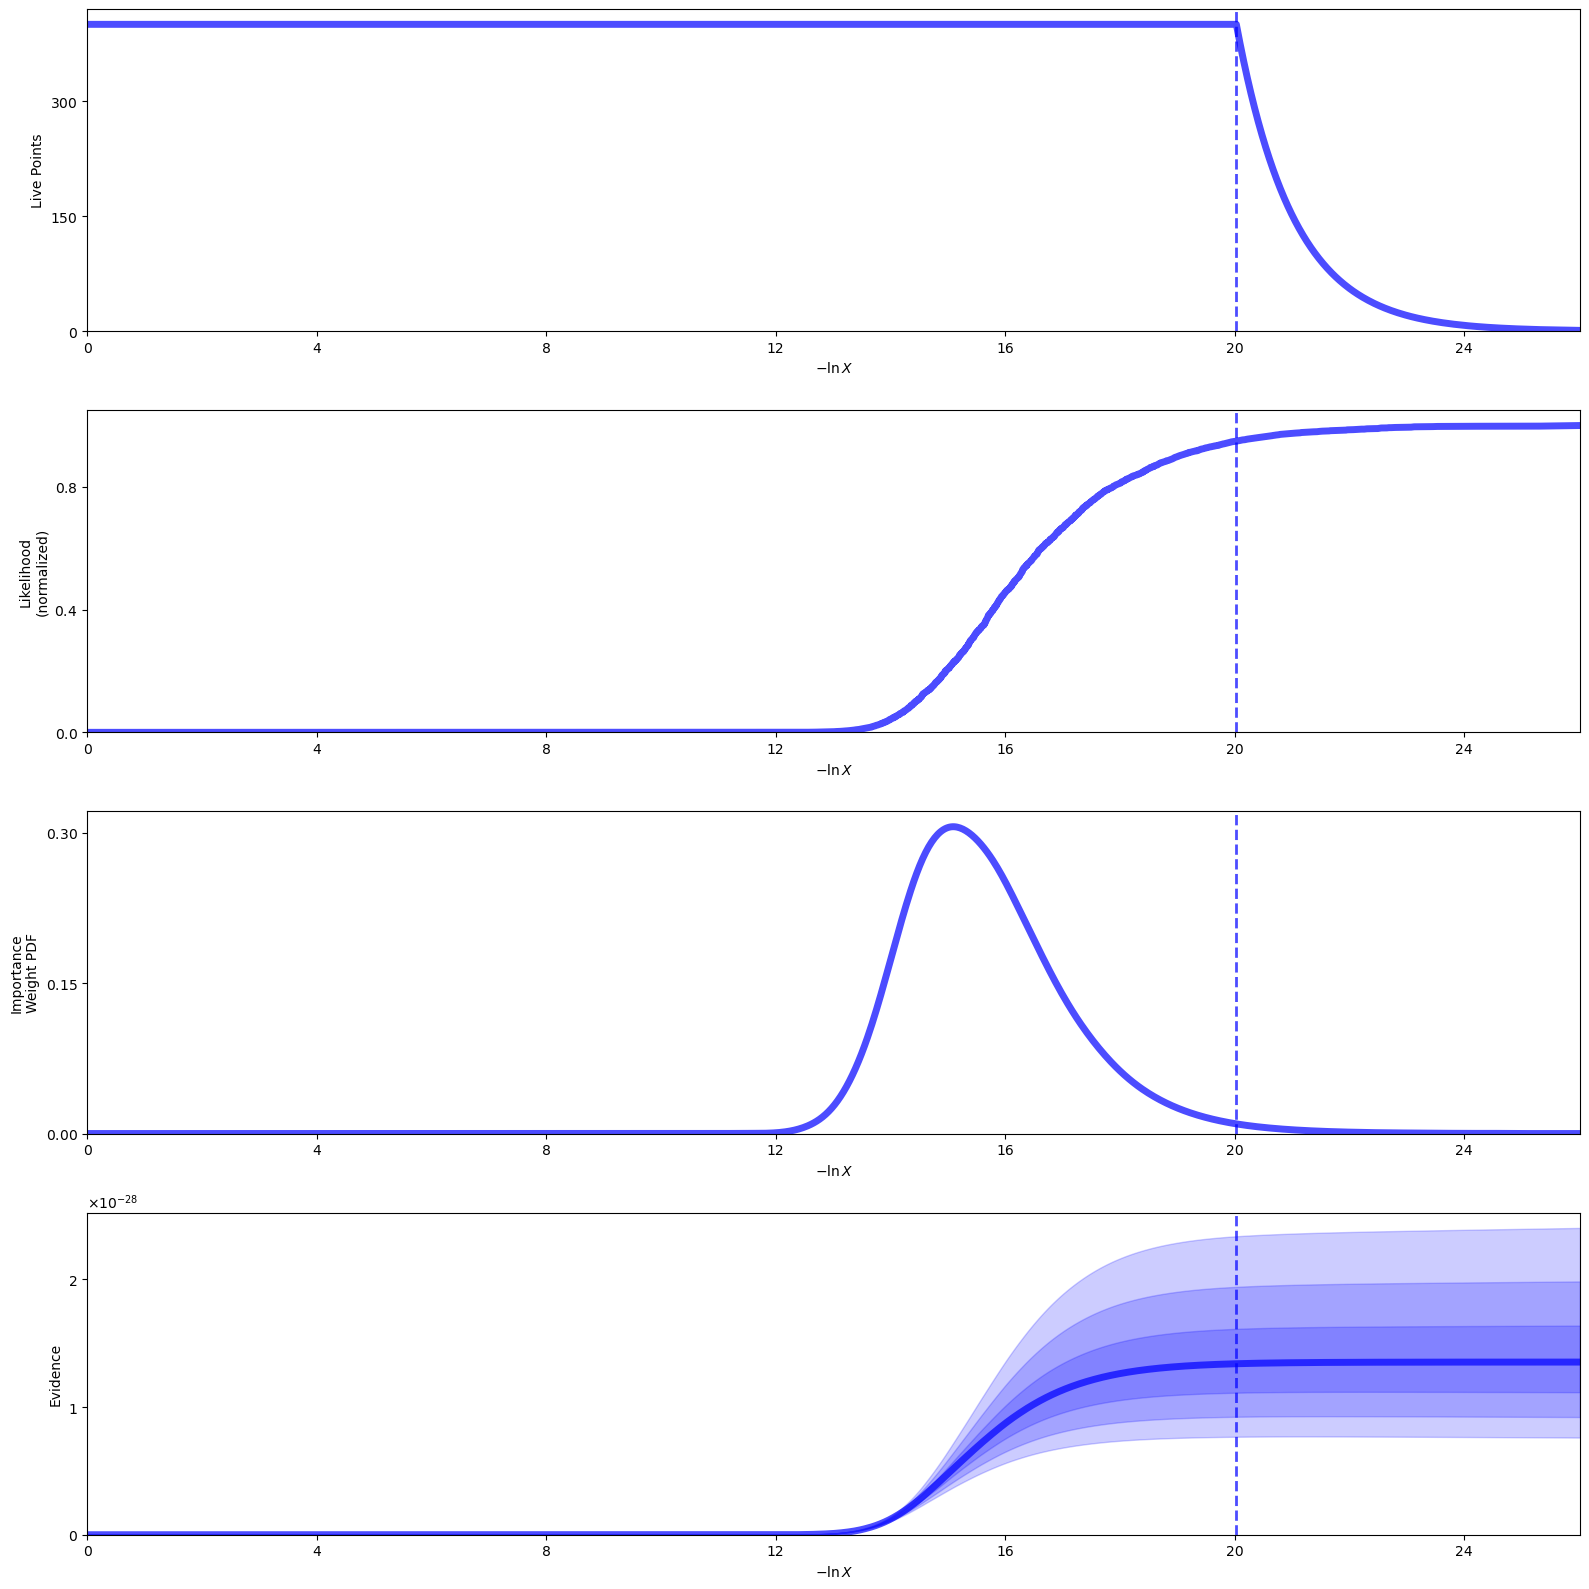

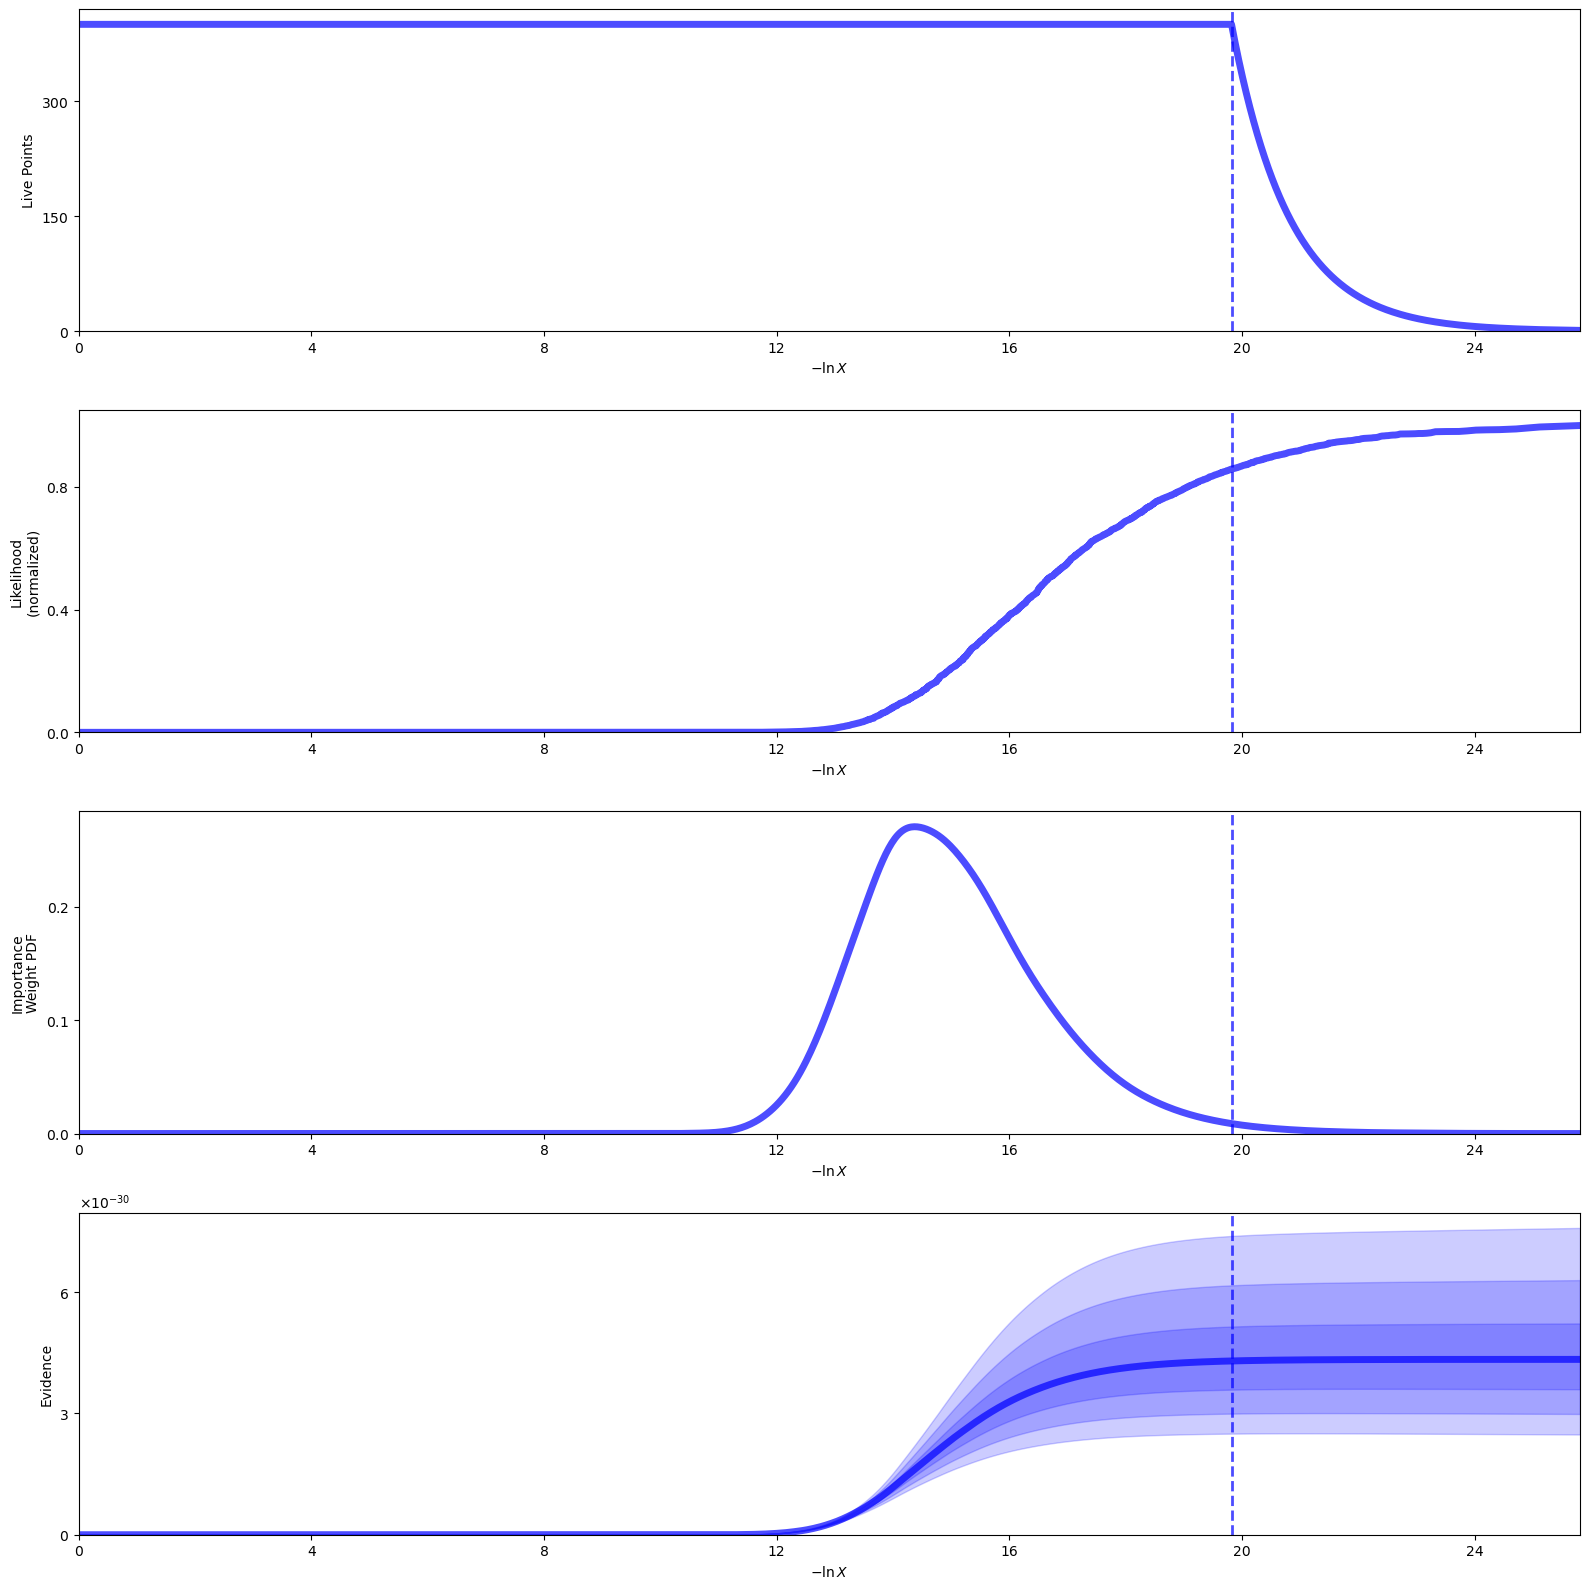

In [7]:

# Run nested sampling
def run_nested(data, loglike_fn, prior_transform_fn, nlive=400, dlogz=0.01, seed=42):
    ndim = 4
    rng = np.random.default_rng(seed)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sampler = dynesty.NestedSampler(
            loglike_fn, prior_transform_fn, ndim,
            logl_args=[data],
            nlive=nlive, rstate=rng, bound='multi', sample='rwalk'
        )
        sampler.run_nested(dlogz=dlogz, print_progress=True)
    return sampler.results

res_burst = run_nested(data, loglike_burst, prior_transform_burst, nlive=400, dlogz=0.01, seed=42)
res_gauss = run_nested(data, loglike_gaussian, prior_transform_gaussian, nlive=400, dlogz=0.01, seed=43)
# dynesty diagnostics: run-plot
dyplot.runplot(res_burst); plt.tight_layout(); plt.show()
dyplot.runplot(res_gauss); plt.tight_layout(); plt.show()



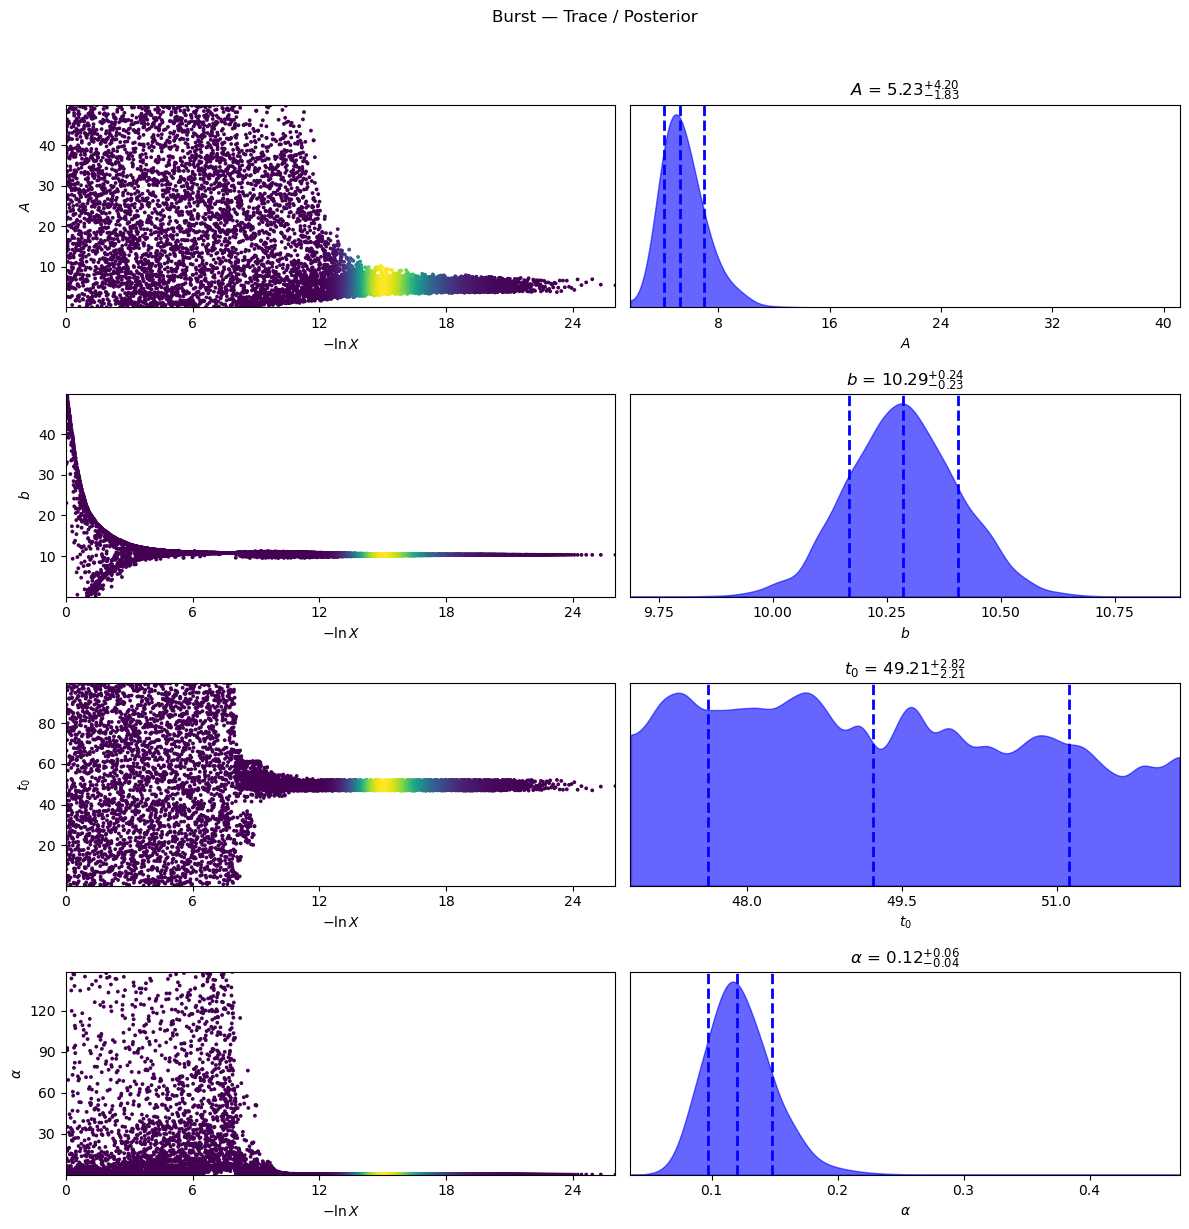

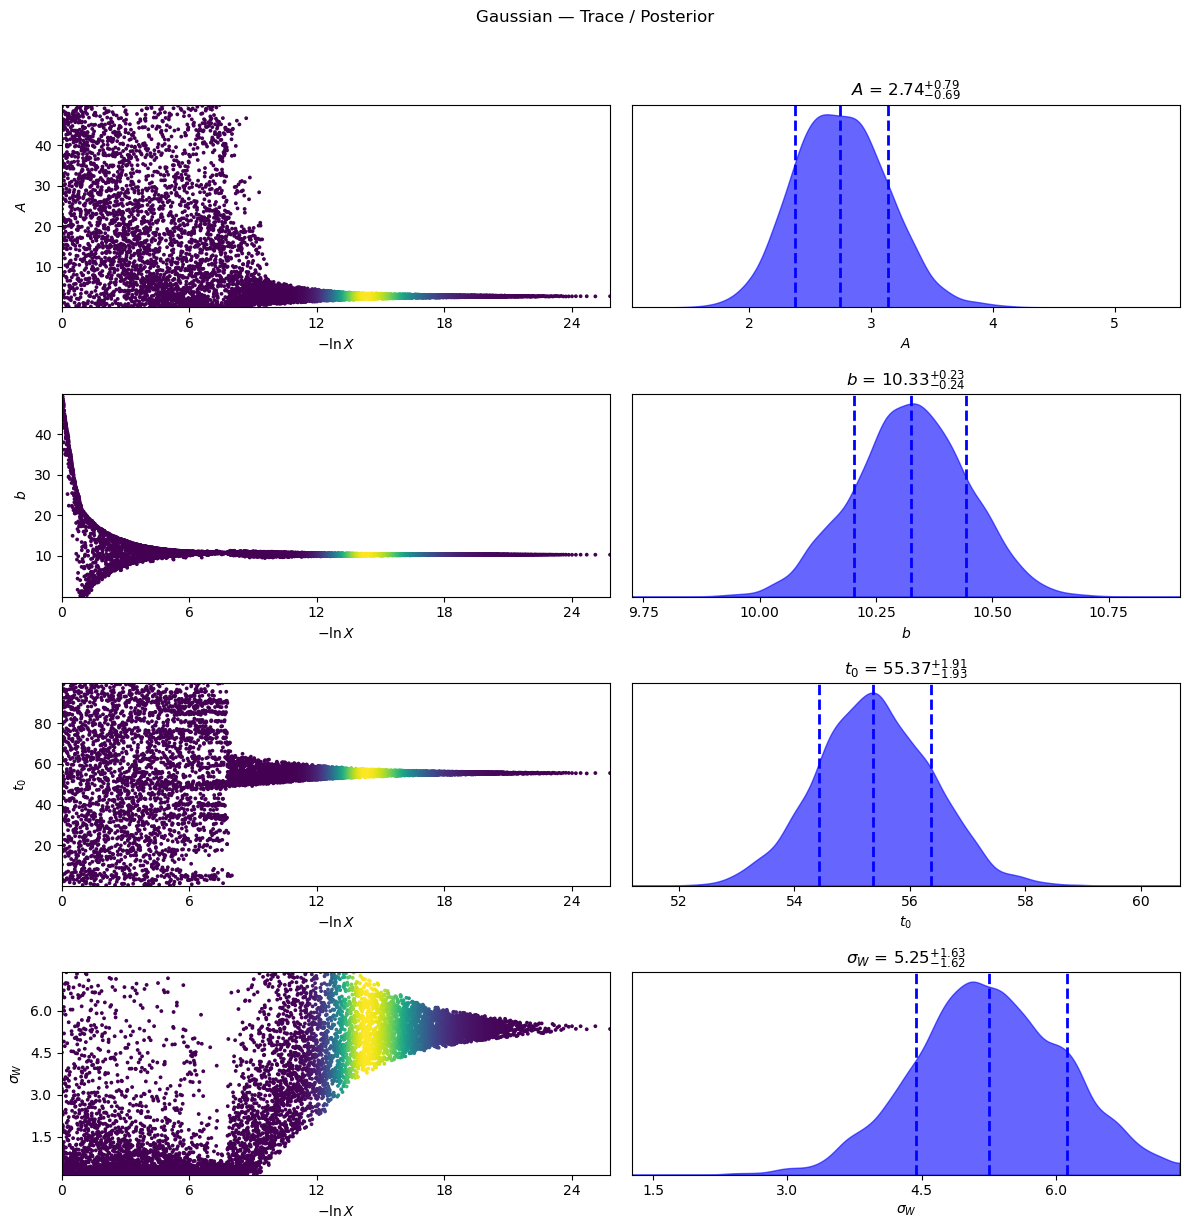

In [8]:
# Dynesty “traceplot” (ln X vs params + 1D marginalized posteriors) 
def make_traceplot(results, param_labels, title_prefix=""):
    fig, axes = dyplot.traceplot(
        results,
        labels=param_labels,
        show_titles=True,
        quantiles=[0.16, 0.5, 0.84],
        trace_cmap='viridis',
    )
    if title_prefix:
        fig.suptitle(f"{title_prefix} — Trace / Posterior", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

make_traceplot(res_burst, [r"$A$", r"$b$", r"$t_0$", r"$\alpha$"], title_prefix="Burst")
make_traceplot(res_gauss, [r"$A$", r"$b$", r"$t_0$", r"$\sigma_W$"], title_prefix="Gaussian")

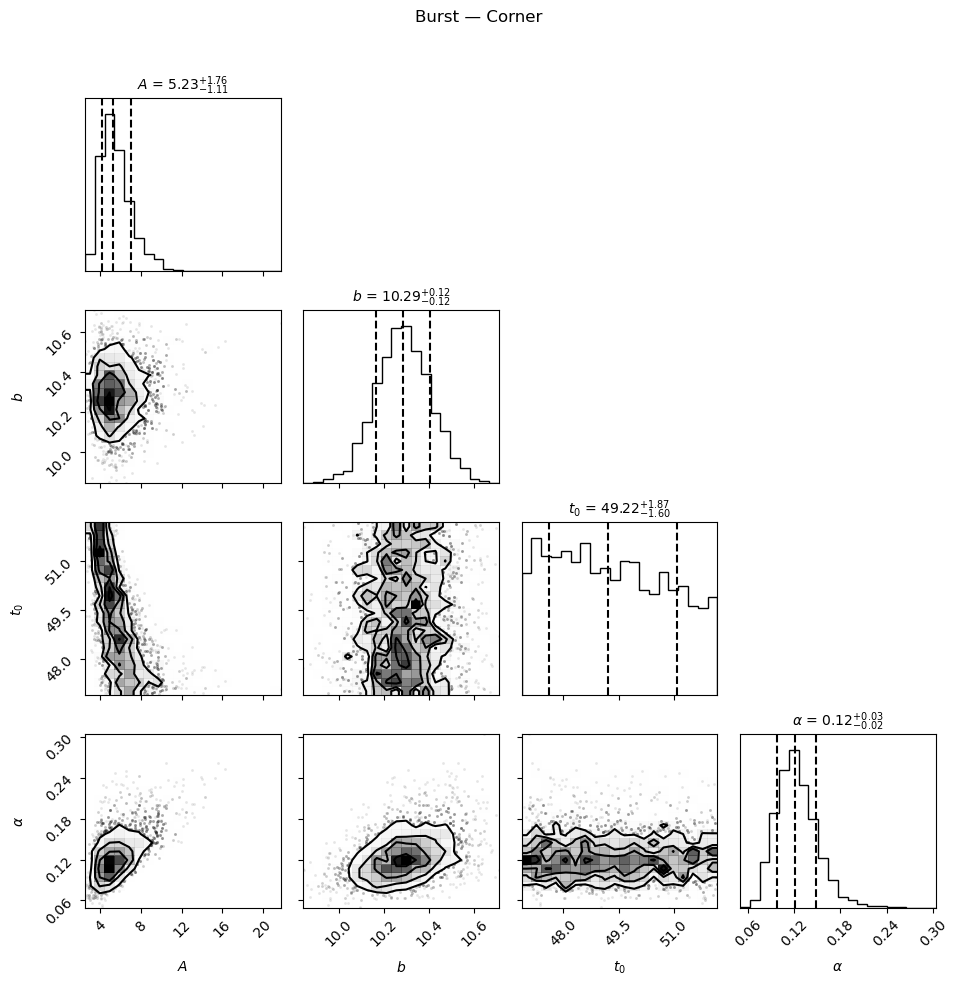

Posterior summary (5%-95% equal-tailed):
  x1(A): 5.2338 (+3.2067, -1.6342)
  x2(b): 10.2854 (+0.2006, -0.1913)
  x3(t0): 49.2148 (+2.6294, -2.0741)
  x4(alpha): 0.1204 (+0.0501, -0.0365)


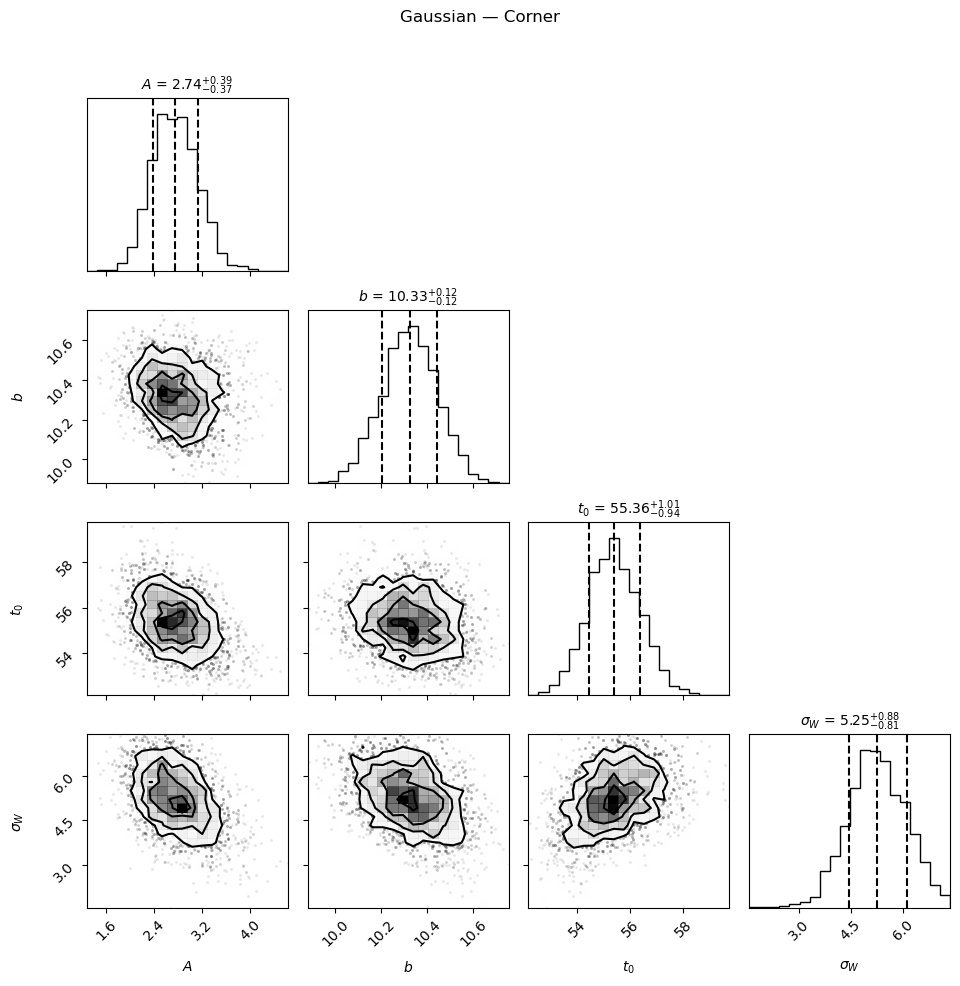

Posterior summary (5%-95% equal-tailed):
  x1(A): 2.7418 (+0.6384, -0.5814)
  x2(b): 10.3254 (+0.1951, -0.2110)
  x3(t0): 55.3659 (+1.6669, -1.5648)
  x4(sigmaW): 5.2486 (+1.4080, -1.3646)


In [9]:

# Post-processing: equal-weight samples, summaries, corner plots
def equal_weight_samples(results):
    weights = np.exp(results.logwt - results.logz[-1])  # normalize
    samples_eq = dyfunc.resample_equal(results.samples, weights)
    return samples_eq, weights

def summarize_posterior(results, labels=("x1","x2","x3","x4"), cred=(5, 50, 95)):
    samples = results.samples
    weights = np.exp(results.logwt - results.logz[-1])
    qs = [dyfunc.quantile(s, [cred[0]/100, cred[1]/100, cred[2]/100], weights=weights) for s in samples.T]
    print("Posterior summary ({}%-{}% equal-tailed):".format(cred[0], cred[2]))
    for (low, med, up), lab in zip(qs, labels):
        print(f"  {lab}: {med:.4f} (+{up-med:.4f}, -{med-low:.4f})")

def make_corner_plots(samples_equal, physical_labels, title_prefix=""):
    fig1 = corner.corner(samples_equal, labels=physical_labels, show_titles=True,
                         quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 10})
    if title_prefix:
        fig1.suptitle(f"{title_prefix} — Corner", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# Post-process
smp_burst_eq, _ = equal_weight_samples(res_burst)
make_corner_plots(smp_burst_eq, physical_labels=[r"$A$", r"$b$", r"$t_0$", r"$\alpha$"],
                title_prefix="Burst")
summarize_posterior(res_burst, labels=("x1(A)", "x2(b)", "x3(t0)", "x4(alpha)"))

smp_gauss_eq, _ = equal_weight_samples(res_gauss)
make_corner_plots(smp_gauss_eq, physical_labels=[r"$A$", r"$b$", r"$t_0$", r"$\sigma_W$"],
                    title_prefix="Gaussian")
summarize_posterior(res_gauss, labels=("x1(A)", "x2(b)", "x3(t0)", "x4(sigmaW)"))



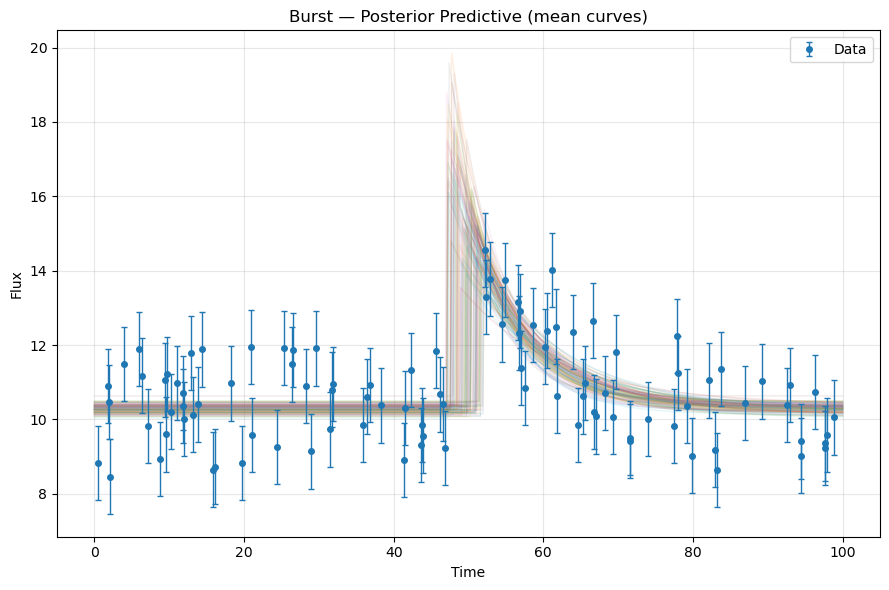

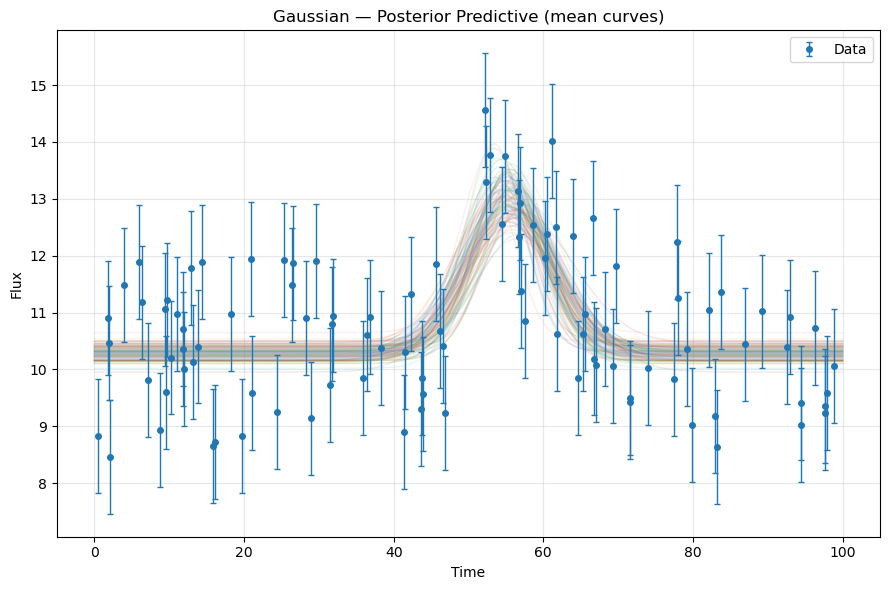

In [10]:
# Posterior predictive (curves)
def posterior_predictive_plot(samples_equal, model_fn, t, y, yerr, name="", nsamples=100):
    t_fine = np.linspace(0, 100, 600)
    idx = np.random.default_rng(0).choice(len(samples_equal), size=min(nsamples, len(samples_equal)), replace=False)
    subset = samples_equal[idx]
    fig, ax = plt.subplots(figsize=(9, 6))
    for th in subset:
        ax.plot(t_fine, model_fn(th, t_fine), alpha=0.12, lw=1)
    ax.errorbar(t, y, yerr=yerr, fmt='o', ms=4, lw=1, capsize=2, label='Data', zorder=5)
    ax.set_xlabel("Time"); ax.set_ylabel("Flux")
    ax.set_title(f"{name} — Posterior Predictive (mean curves)")
    ax.legend(); ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

posterior_predictive_plot(smp_burst_eq, burst_model, t, y, yerr, name="Burst", nsamples=100)
posterior_predictive_plot(smp_gauss_eq, gaussian_model, t, y, yerr, name="Gaussian", nsamples=100)


In [11]:
#  Evidence + Jeffreys scale
def jeffreys_interpretation(bayes_factor):
    if bayes_factor > 100:
        return "Very strong evidence"
    elif bayes_factor > 10:
        return "Strong evidence"
    elif bayes_factor > 3:
        return "Substantial evidence"
    else:
        return "Inconclusive"

def compare_evidence(res_burst, res_gauss):
    logZ_burst, logZerr_burst = res_burst.logz[-1], res_burst.logzerr[-1]
    logZ_gauss, logZerr_gauss = res_gauss.logz[-1], res_gauss.logzerr[-1]
    dlogZ = logZ_burst - logZ_gauss
    dlogZ_err = np.sqrt(logZerr_burst**2 + logZerr_gauss**2)
    K = np.exp(dlogZ)
    favored = "Burst" if dlogZ > 0 else "Gaussian"
    print("\n=== Bayesian Evidence ===")
    print(f"  log Z (Burst)    = {logZ_burst:.3f} ± {logZerr_burst:.3f}")
    print(f"  log Z (Gaussian) = {logZ_gauss:.3f} ± {logZerr_gauss:.3f}")
    print(f"  Δlog Z (Burst − Gaussian) = {dlogZ:.3f} ± {dlogZ_err:.3f}")
    print(f"  Bayes factor K (Burst / Gaussian) = {K:.3f}")
    print(f"  Jeffreys scale: {jeffreys_interpretation(K)}.")
    print(f"\n>>> Preferred model: **{favored}** <<<\n")
    return dlogZ, dlogZ_err, K, favored

#Compare the  Evidence + Jeffreys scale comparison 
compare_evidence(res_burst, res_gauss)


=== Bayesian Evidence ===
  log Z (Burst)    = -64.171 ± 0.192
  log Z (Gaussian) = -67.611 ± 0.186
  Δlog Z (Burst − Gaussian) = 3.440 ± 0.267
  Bayes factor K (Burst / Gaussian) = 31.174
  Jeffreys scale: Strong evidence.

>>> Preferred model: **Burst** <<<



(3.4395962480164997, 0.26742567137291906, 31.17436891372894, 'Burst')